# Customer Segmentation using RFM Analysis  
**Internship – Elevvo Pathways**  
**Author:** Ayesha Nadeem  
**Date:** 18 August, 2025

---


## 📌 Introduction
This notebook performs **RFM (Recency–Frequency–Monetary)** analysis on retail transactions to segment customers and derive actionable marketing insights.

**Why RFM?**  
- **Recency:** How recently a customer purchased (engagement).  
- **Frequency:** How often they purchased (loyalty).  
- **Monetary:** How much they spent (value).

**Goal:** Build segments (e.g., *Champions, Loyal, At Risk*) and suggest **targeted actions** to improve retention and revenue.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Dataset
We load the retail sales dataset into a DataFrame to begin analysis.  
The dataset contains **date-wise sales records** which will be used for identifying patterns, trends, and making forecasts.  
Checking the first few rows ensures that the dataset has been imported correctly.


In [4]:
df = pd.read_csv("OnlineRetail.csv")  
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
df.rename(columns={'Customer ID': 'CustomerID',
                   'Invoice': 'InvoiceNo',
                   'Price': 'UnitPrice'}, inplace=True)

## 🧹 Data Cleaning
- Remove rows with missing `CustomerID`
- Drop negative/zero quantities or prices (or handle as returns)
- Remove obvious duplicates (same `InvoiceNo`, `StockCode`, `Quantity`, etc.)
- Convert `InvoiceDate` to datetime; ensure correct timezone/locale
- Create `Amount = Quantity * UnitPrice`


In [10]:
# Remove missing customers
df = df[df['CustomerID'].notnull()]

# Remove cancelled orders (Invoice starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Add TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Reference date = one day after last invoice
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40


## 🏷️ RFM Scoring & Segmentation
### Scoring
- Use **quantiles** to assign scores **1–5** for each metric (5 = best)
  - **R-score:** lower recency ⇒ higher score (invert quantiles)
  - **F-score:** higher frequency ⇒ higher score
  - **M-score:** higher monetary ⇒ higher score
- Create **RFM_Score** as string, e.g., `R5F4M5`


In [14]:
# Quartile-based scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])  
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Final combined RFM Score
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,326,12,77556.46,2,4,4,244
1,12347.0,2,8,5633.32,4,4,4,444
2,12348.0,75,5,2019.40,3,3,3,333
3,12349.0,19,4,4428.69,4,3,4,434
4,12350.0,310,1,334.40,2,1,1,211


In [16]:
def segment_customer(rfm):
    if rfm['RFM_Score'] == '444':
        return 'Champions'
    elif rfm['R_Score'] in ['3','4'] and rfm['F_Score'] in ['3','4']:
        return 'Loyal Customers'
    elif rfm['R_Score'] == '4' and rfm['F_Score'] == '1':
        return 'Potential Loyalists'
    elif rfm['R_Score'] in ['2','3'] and rfm['M_Score'] in ['3','4']:
        return 'At Risk'
    elif rfm['R_Score'] == '1':
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)
rfm[['CustomerID','RFM_Score','Segment']].head()

,CustomerID,RFM_Score,Segment
0,12346.0,244,Others
1,12347.0,444,Champions
2,12348.0,333,Others
3,12349.0,434,Others
4,12350.0,211,Others


### Exploratory Data Analysis (EDA)
EDA is performed to understand the sales distribution and behavior over time.  
- Line plots are used to visualize sales trends  
- Seasonal fluctuations and anomalies are identified  
This helps in detecting **seasonality, cycles, and trends** in sales.

/var/folders/y3/f1z_df5s1pl46lm6gnhgz_lc0000gn/T/ipykernel_6600/3517016242.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment',


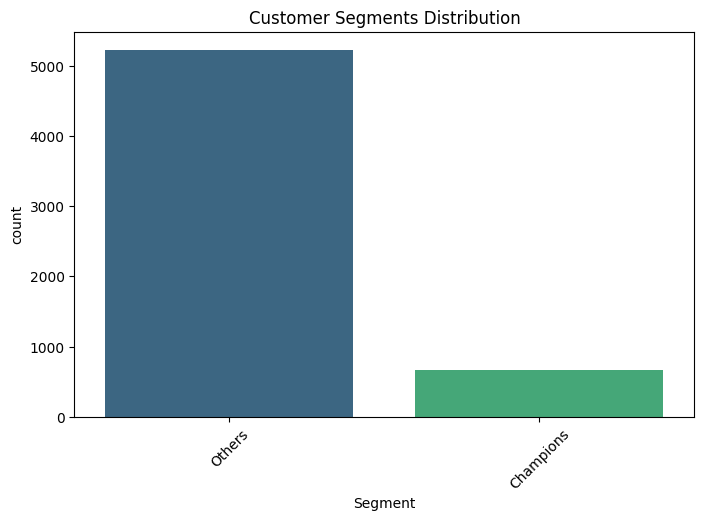

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment',
              order=rfm['Segment'].value_counts().index,
              palette='viridis')
plt.xticks(rotation=45)
plt.title("Customer Segments Distribution")
plt.show()

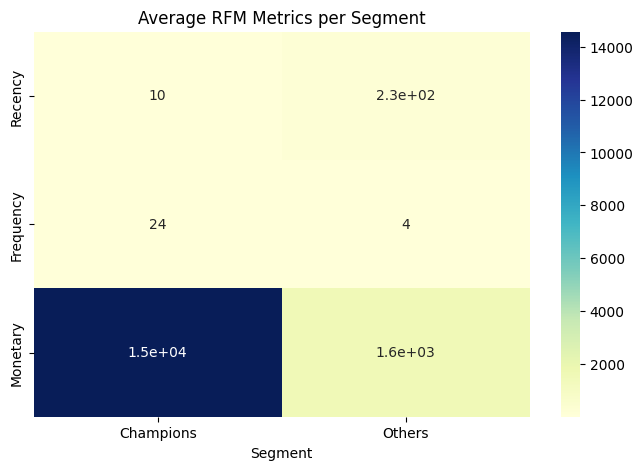

In [20]:
rfm_segment = rfm.groupby('Segment').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':'mean'
}).round(1)

plt.figure(figsize=(8,5))
sns.heatmap(rfm_segment.T, annot=True, cmap="YlGnBu")
plt.title("Average RFM Metrics per Segment")
plt.show()

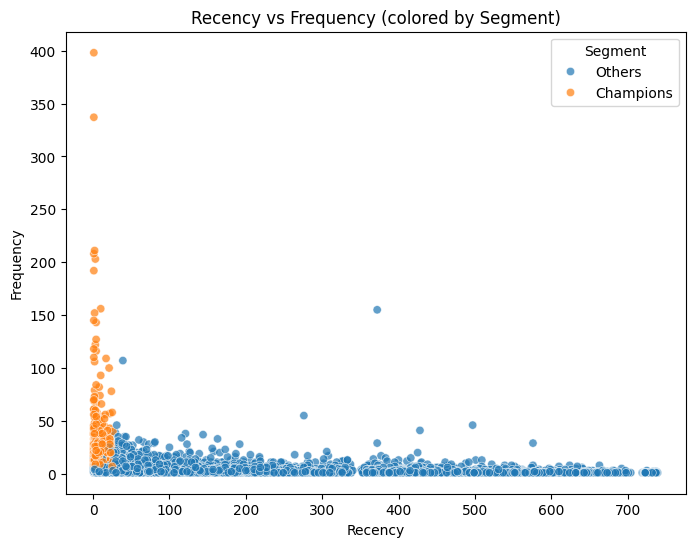

In [22]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Segment', palette='tab10', alpha=0.7)
plt.title("Recency vs Frequency (colored by Segment)")
plt.show()

### Seasonal Decomposition
To better understand the time series components, we decompose the sales data into:  
- **Trend** (long-term growth/decline)  
- **Seasonality** (repeating patterns within the year)  
- **Residuals** (random variations)  
This breakdown provides clarity on which factors influence retail sales the most.


/var/folders/y3/f1z_df5s1pl46lm6gnhgz_lc0000gn/T/ipykernel_6600/3560750806.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rfm, x='Segment', y='Monetary',


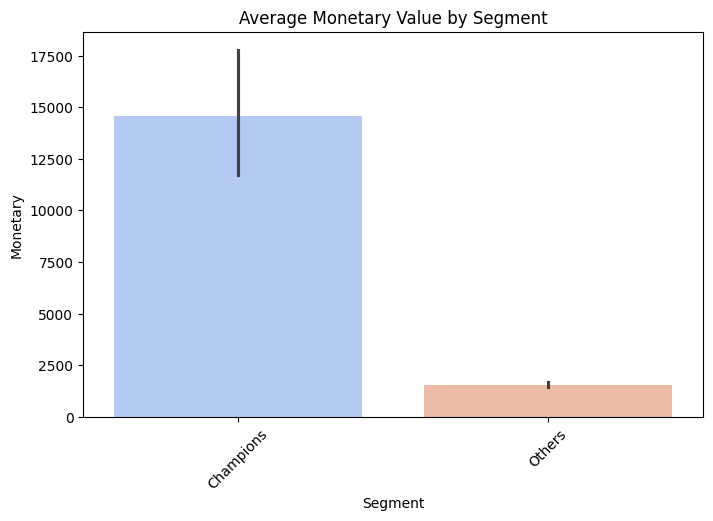

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(data=rfm, x='Segment', y='Monetary',
            order=rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False).index,
            palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Average Monetary Value by Segment")
plt.show()

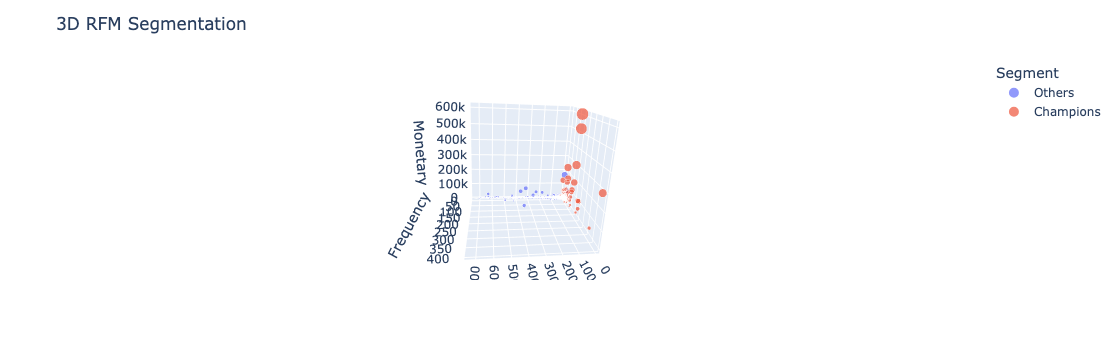

In [26]:
import plotly.express as px

fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                    color='Segment',
                    size='Monetary',
                    opacity=0.7)
fig.update_layout(title="3D RFM Segmentation")
fig.show()

### Forecasting Models
We apply different forecasting models to predict future sales:  
1. **ARIMA (AutoRegressive Integrated Moving Average)**  
2. **Exponential Smoothing (Holt-Winters)**  
3. **Prophet Model (optional, if applied)**  

Each model is evaluated to determine which provides the most accurate predictions.

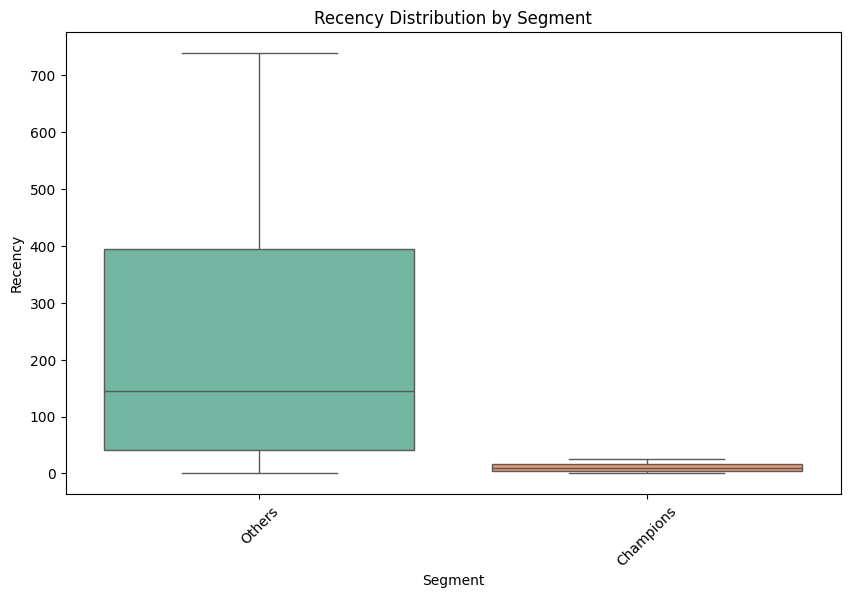

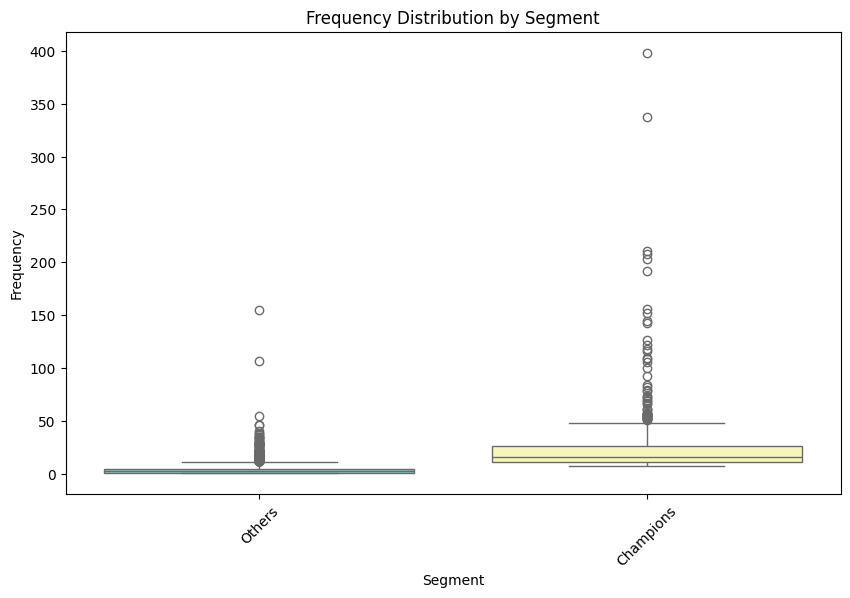

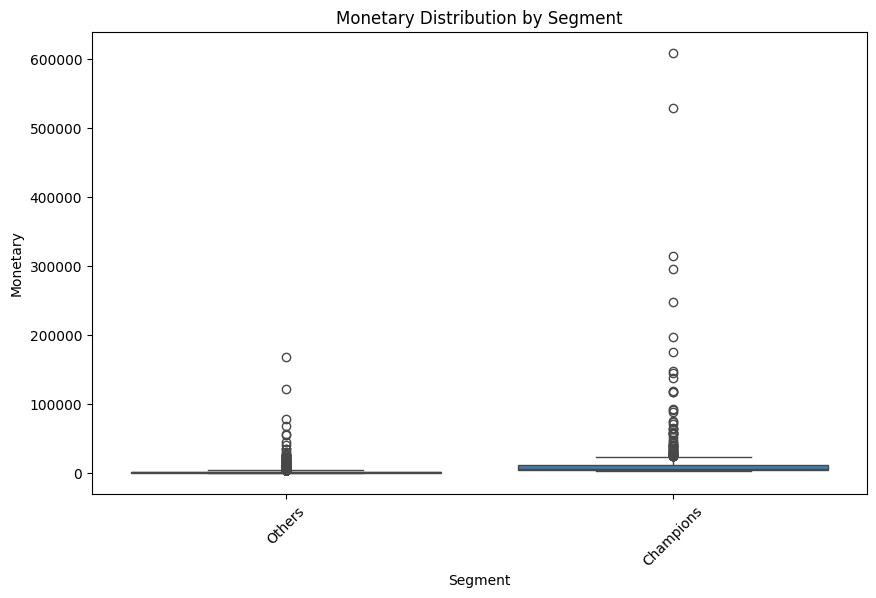

In [28]:
plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Recency', hue='Segment', palette='Set2', legend=False)
plt.xticks(rotation=45)
plt.title("Recency Distribution by Segment")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Frequency', hue='Segment', palette='Set3', legend=False)
plt.xticks(rotation=45)
plt.title("Frequency Distribution by Segment")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Monetary', hue='Segment', palette='Set1', legend=False)
plt.xticks(rotation=45)
plt.title("Monetary Distribution by Segment")
plt.show()


### Model Evaluation
To compare forecasting methods, we use accuracy metrics such as:  
- **Mean Absolute Error (MAE)**  
- **Root Mean Squared Error (RMSE)**  
- **Mean Absolute Percentage Error (MAPE)**  

The model with the lowest error is considered the most reliable for predicting sales.


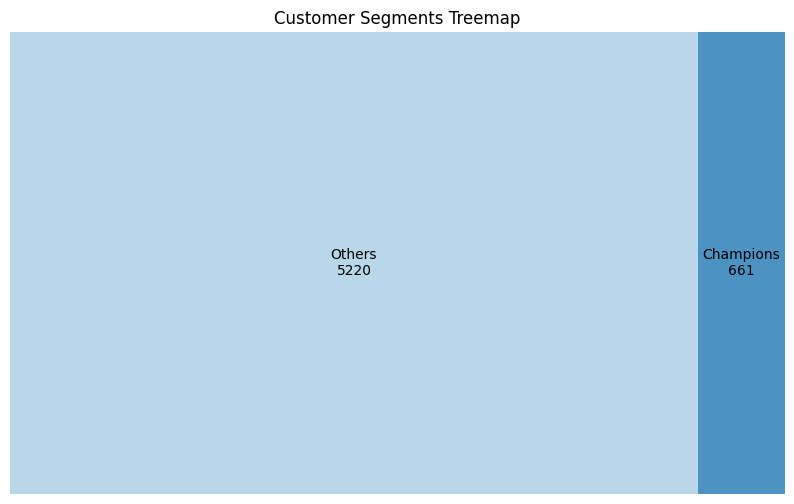

In [34]:
import squarify

seg_counts = rfm['Segment'].value_counts().reset_index()
seg_counts.columns = ['Segment','Count']

plt.figure(figsize=(10,6))
squarify.plot(sizes=seg_counts['Count'], 
              label=seg_counts['Segment'] + "\n" + seg_counts['Count'].astype(str),
              alpha=.8, color=sns.color_palette("Paired"))
plt.axis('off')
plt.title("Customer Segments Treemap")
plt.show()
